In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from sklearn import metrics
import tabulate
import itertools
import matplotlib.patches as mpatches
import umap
from importlib import reload
from scipy import stats
from scipy.stats import ranksums
import matplotlib.image as mpimg
import goatools
from goatools.anno.gaf_reader import GafReader
import Bio.UniProt.GOA as GOA
import gget
import sys

# locals
sys.path.append("../")
import utils as ut
reload(ut)

2023-04-17 16:52:05.295780: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-17 16:52:05.410747: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/slurm/lib64:
2023-04-17 16:52:05.410770: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-17 16:52:05.436761: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-17 16:52:06.5225

<module 'utils' from '/home/cstansbu/git_repositories/spatial_transcriptomics/clustering/validation/../utils.py'>

In [4]:
cardDir =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"
xyPath =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/combinedEmbedding.csv"
xy = pd.read_csv(xyPath)
cTypes = sorted(list(xy['cellTypes'].unique()))
print(cTypes)
print()

keys = ['ND', 'HFD8', 'HFD14']

rna = {}
labels = {}

for key in keys:
    print(f"{key}...")
    labelPath = f"{cardDir}{key}_macrophage_clusters.csv"
    lf = pd.read_csv(labelPath)
    
    lf = pd.merge(lf, xy[['x', 'y', 'cellId', 'colors']], 
                  how='left',
                  left_on='cellId',
                  right_on='cellId')
    
    labels[key] = lf

print('done')

['B cells', 'Dendritic cells', 'Macrophages', 'Monocytes', 'NK cells', 'Stromal cells', 'T cells']

ND...
HFD8...
HFD14...
done


In [47]:
antiPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/antibodies/"

keys = ['ND', 'HFD8', 'HFD14']

anti = {}

for key in keys:
    fPath = f"{antiPath}{key}.csv"
    af = pd.read_csv(fPath)
    af = af.rename(columns={'Unnamed: 0' : 'cellId'})
    af['cellId'] = af['cellId'].apply(lambda x: str(x).replace("-", "."))
    af = af.set_index('cellId')
    print(key, af.shape)
    anti[key] = af
    
    # print(af.head())
    
    print()
    

print('done')

ND (1414, 8)

HFD8 (6558, 8)

HFD14 (7146, 8)

done


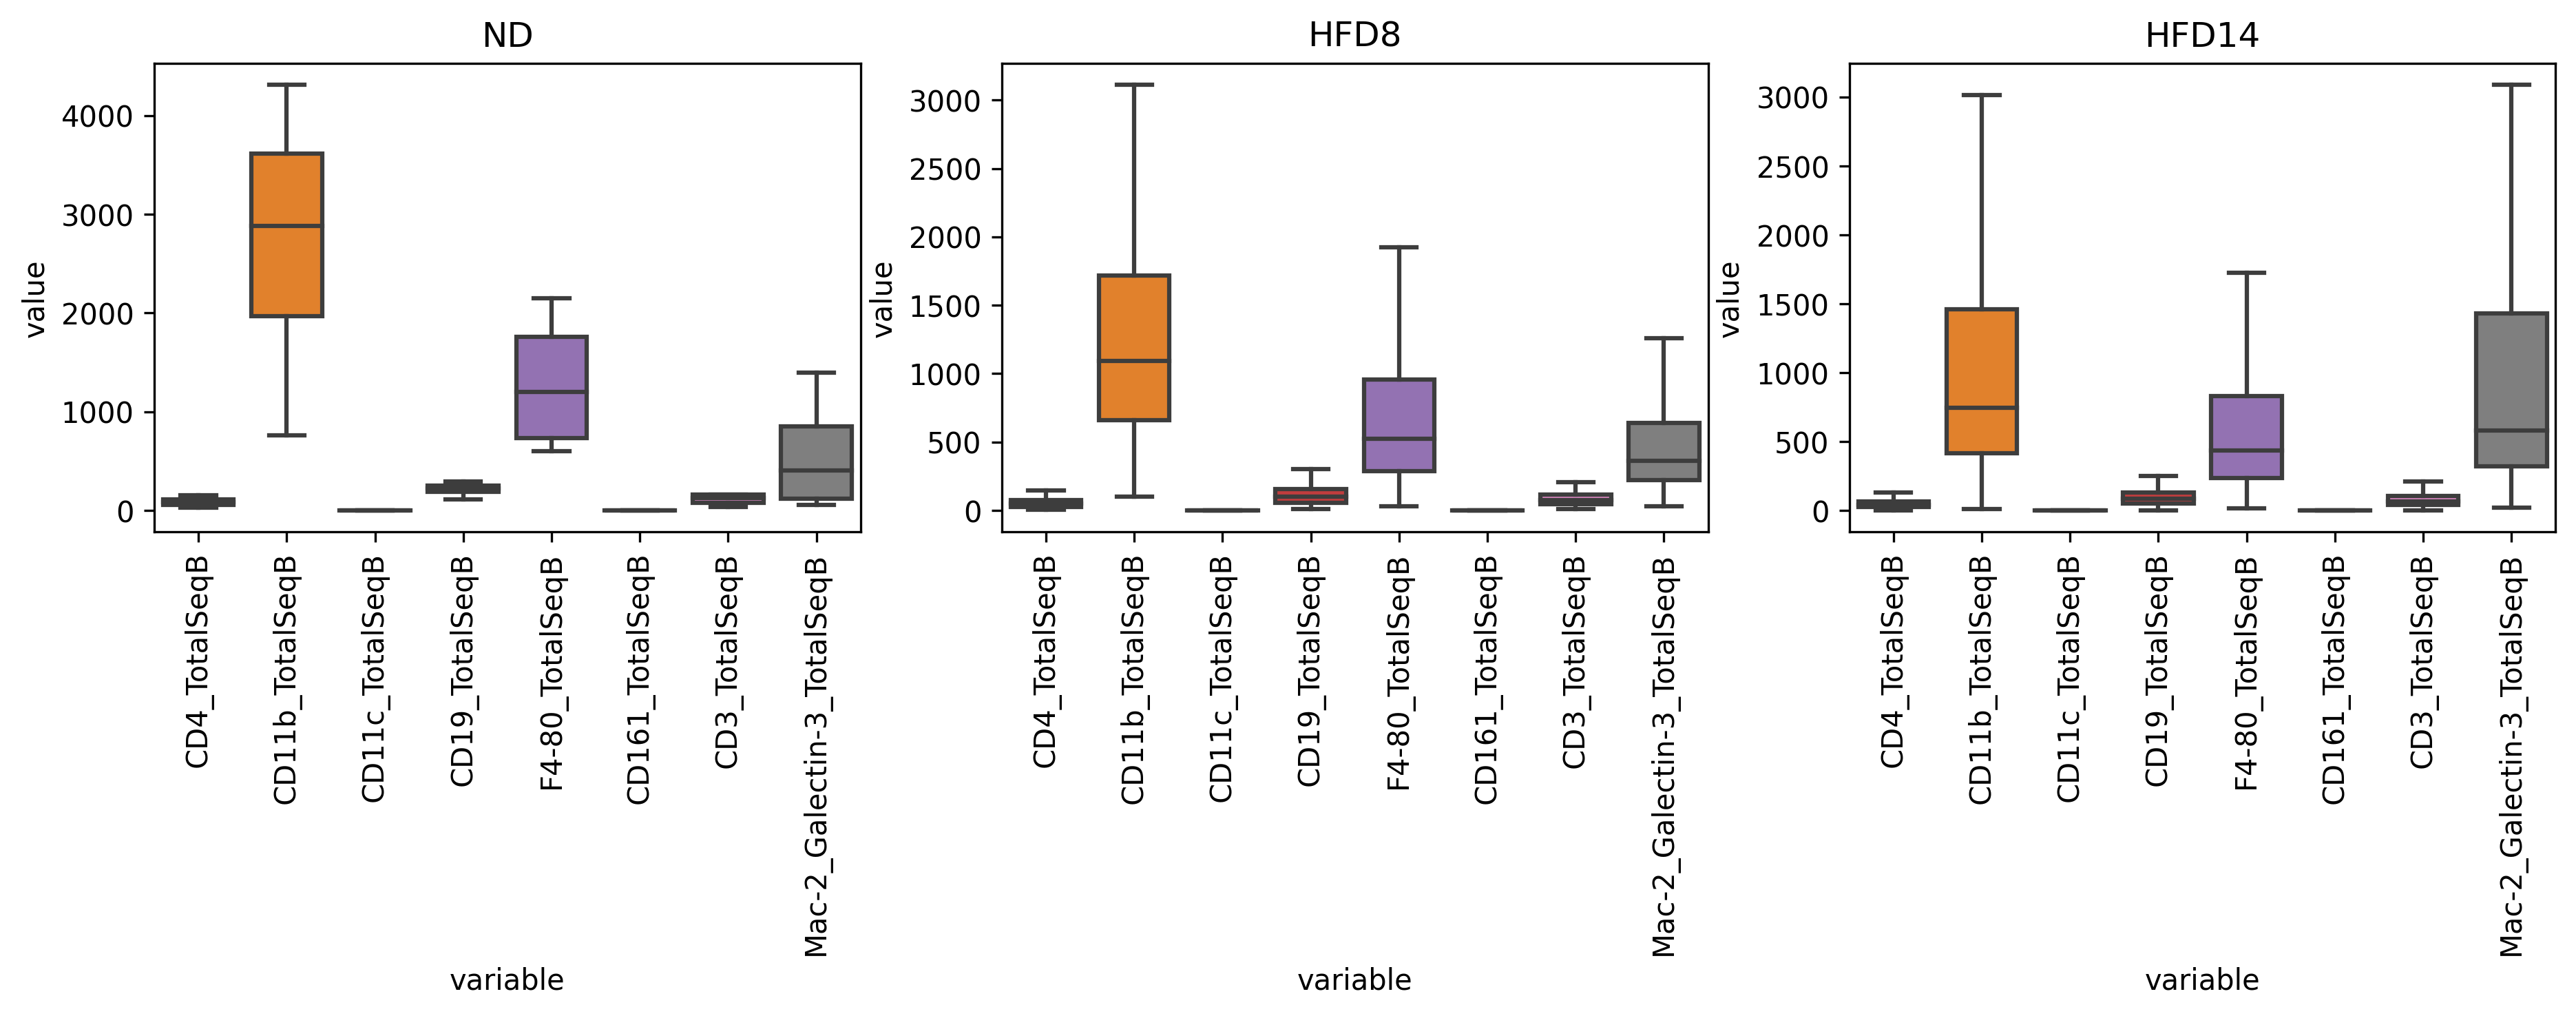

In [70]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 15, 3

fig, axs = plt.subplots(1, 3)
axs = axs.ravel()
ctype = 'Mac5'


for i, key in enumerate(keys):
    af = anti[key]
    prots = af.columns
    lf = labels[key]
    
    lf = pd.merge(lf, af, 
                  how='left',
                  left_on='cellId',
                  right_index=True)
    
    pdx = pd.melt(lf, id_vars=['cellId', 'cellType'],
                  value_vars=prots)
    

    pdx = pdx[pdx['cellType'] == ctype]
    sns.boxplot(data=pdx, 
               x='variable', 
               y='value', 
               showfliers=False,
               ax=axs[i])
          
    axs[i].tick_params(axis='x', rotation=90)
    axs[i].set_title(key)
    
    # break

In [44]:
lf.head()

,cellId,cellType,sampleInfo,x,y,colors,CD4_TotalSeqB,CD11b_TotalSeqB,CD11c_TotalSeqB,CD19_TotalSeqB,F4-80_TotalSeqB,CD161_TotalSeqB,CD3_TotalSeqB,Mac-2_Galectin-3_TotalSeqB,key
0,AAACGAACAGCAGTAG.1,B cells,ND,6.783486,1.839065,#9e0142,18.0,19.0,0.0,37.0,25.0,0.0,17.0,32.0,HFD14
1,AAAGAACGTCTACAGT.1,Mac1,ND,3.089298,-1.726030,#fdbf6f,10.0,176.0,0.0,25.0,57.0,0.0,14.0,16.0,HFD14
2,AAAGAACTCCTCGCAT.1,Mac1,ND,3.614130,-1.571004,#fdbf6f,55.0,1593.0,0.0,95.0,612.0,0.0,69.0,114.0,HFD14
3,AAAGGGCGTTAGGGTG.1,Mac3,ND,3.086352,6.166065,#fdbf6f,52.0,1020.0,0.0,85.0,54.0,0.0,55.0,72.0,HFD14
4,AACAAAGAGTATAGGT.1,Monocytes,ND,3.178745,4.929769,#ffffbe,60.0,3674.0,0.0,122.0,205.0,0.0,70.0,87.0,HFD14
